# Change point examples

This notebook contains the examples from **Google Books dataset, Congressional records dataset, UN debates dataset**.


In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np

from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = False # 
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
figsize = (900/96*2, 500/96*1.4) # original size
# figsize = (1500/96, 600/96)
dpi = 96
fig = plt.figure(figsize=figsize, dpi=dpi)

def plot_trajectory(target_words, time_interest, embeddings, 
                    start_year=1875, end_year=2011, incre=2, topk=10, tickgap=5, 
                    canvas=None, lcolor='C0', wcolor='black', alpha=1.0, upwards=None,
                    figsize=(900/96, 500/96), fig=fig, pos=321, updown_thres=0.54,
                    y_bom=-0.05, y_up=1.05, x_left_zero=100, x_right_lim_offset=0, label_text='',
                    x_offset_list=None, y_offset_list=None, show_leftticklabels=True
                    ):
    from plot_lib.plot import PlotMeaningShift, PlotTrajectory
    from plot_lib.shifts_measure import find_change_words
    from plot_lib.trajectory import plot_trajectories, get_neighbors_by_index, get_trajectory
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'Computer Modern Sans serif'
    
    trajectories = get_trajectory(target_words, embeddings, vocab)
    word2neighbors, timestep_idx = get_neighbors_by_index(
        time_interest, 
        target_words, embeddings, vocab, topk=topk)
    
    if x_offset_list is None:
        x_offset_list = [0.0] * len(time_interest)
    
    if y_offset_list is None:
        y_offset_list = [0.0] * len(time_interest)

    year_map = list(range(start_year, end_year + 1, incre))
    for word in target_words:
        trajectory = trajectories[:, target_words.index(word)]
        # print(trajectory)
        if canvas is None:
            canvas = PlotTrajectory(start_year, end_year, incre, figsize=figsize, fig=fig, pos=pos) #, dpi=96, figsize=(900/96, 500/96))
            canvas.set_style(y_bom=y_bom, y_up=y_up, x_left_zero=x_left_zero, x_right_lim_offset=x_right_lim_offset, 
                             tickgap=tickgap, show_leftticklabels=show_leftticklabels)
        canvas.ax.plot(trajectory, lw=2, color=lcolor, alpha=alpha, label=label_text)
        neighbors = word2neighbors[word]
        if upwards is None:
            for (i, x_offset, y_offset) in zip(range(len(timestep_idx)), x_offset_list, y_offset_list):
                if trajectory[timestep_idx[i]] > updown_thres:
                    canvas.plot_wordset(year_map[timestep_idx[i]], 
                                        neighbors[i], 
                                        offset=trajectory[timestep_idx[i]] + y_offset, # y_up,
                                        marker_offset=trajectory[timestep_idx[i]],
                                        color=wcolor,
                                        upwards=False,
                                        alpha=alpha,
                                        x_offset=x_offset,
                                        group_height=0.8,
                                        wsize=12)
                else:
                    canvas.plot_wordset(year_map[timestep_idx[i]], 
                                        neighbors[i], 
                                        offset=trajectory[timestep_idx[i]] + y_offset, # y_bom, # 
                                        marker_offset=trajectory[timestep_idx[i]],
                                        color=wcolor,
                                        upwards=True,
                                        alpha=alpha,
                                        x_offset=x_offset,
                                        group_height=0.8,
                                        wsize=12)
        else:
            for i in range(len(timestep_idx)):
                canvas.plot_wordset(year_map[timestep_idx[i]], 
                                    neighbors[i], 
                                    offset=trajectory[timestep_idx[i]], 
                                    color=wcolor,
                                    upwards=upwards,
                                    alpha=alpha,
                                    x_offset=x_offset,
                                    group_height=0.8,
                                    wsize=12)
    return canvas

<Figure size 1800x700 with 0 Axes>

In [4]:
ALPHA = 0.2

## Congressional records

PARAMS: v30000 d100 diff2 prior-10

plot 1875 - 2011

In [5]:
# vocabulary
vocab_size = 30000
vocab_path = './data-n-ckpt/crecords/vocab100000.tsv'
with open(vocab_path) as file:
    file.readline() # skip first line
    tot_vocab = [line.split('\t')[0] for line in file.readlines()]
vocab = tot_vocab[:vocab_size]
print(np.asarray(vocab)[np.random.randint(0, 1000, 10)])

# embeddings
beam_decision = np.load(
    './data-n-ckpt/crecords/v30000_d100_b8_p-10_diff2.000000_crecords/beam_results/'
    'beam_decision_v30000_d100_b8_y111.npy')
beam_mu = np.load(
    './data-n-ckpt/crecords/v30000_d100_b8_p-10_diff2.000000_crecords/beam_mu_111.npy')

print('shape of beam_decision', beam_decision.shape)
print('shape of beam_mu', beam_mu.shape)

['Does' 'funding' 'is' 'coming' 'assistance' 'As' 'word' 'cent' 'Mexico'
 'commission']
shape of beam_decision (8, 30000, 69)
shape of beam_mu (8, 30000, 100, 69)


In [6]:
# delayed update for embeddings
from local_jump_dsg_beam_search_crecords import delayed_update_procedure

beam_dize = 8
beam_interest = 0
vocab_size = 30000
emb_dim = 100
num_years = 69

embeddings_list = []
for beam_interest in range(beam_dize):
    embeddings_list.append(delayed_update_procedure(beam_decision, 
                                         beam_mu,
                                         num_years,
                                         update=True,
                                         beam_id=beam_interest, 
                                         vocab_size=vocab_size, emb_dim=emb_dim))

embeddings_list = np.array(embeddings_list)
print('(num_beam, num_years, num_words, num_dimensions): ', embeddings_list.shape)

(num_beam, num_years, num_words, num_dimensions):  (8, 69, 30000, 100)


In [7]:
# plot setting
start_year = 1875
end_year = 2011
incre = 2
k_neighbor = 10
tickgap = 10

target_words = ['atom']
print('id: ', vocab.index(target_words[0]))
time_interest = [(1945 - start_year)//2, (2011 - start_year)//2]
embeddings = embeddings_list[0]
canvas = plot_trajectory(target_words, time_interest, embeddings[int((start_year - 1875)//2):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap,
                         lcolor='C0', wcolor='C0', upwards=None, alpha=1.0, updown_thres=0.4,
                         figsize=(600/96, 500/96), pos=232, show_leftticklabels=False,
                         label_text="jumpy '%s' vectors" % target_words[0],
                         x_offset_list=[-9, -6.5], y_offset_list=[0.35, 0])

color = 1
for embeddings in embeddings_list[1:]:
    time_interest = [] #[(1945 - start_year)//2, (2011 - start_year)//2] #[(1895 - start_year)//2, (1971 - start_year)//2]
    canvas = plot_trajectory(target_words, time_interest, embeddings[int((start_year - 1875)//2):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap, 
                         canvas=canvas, lcolor='C%d' % color, wcolor='C%d' % color, upwards=None, alpha=ALPHA, updown_thres=0.5,
                         label_text="regular '%s' vectors" % target_words[0],
                         x_offset_list=[-3.0, -1], y_offset_list=[0.3, 0])
    color += 1


canvas.ax.set_title('Congressional records', fontsize=20)
canvas.ax.text(-1, 1.0, '"%s"' % target_words[0], size=18, verticalalignment='top', color="C0")

id:  14742


Text(-1, 1.0, '"atom"')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


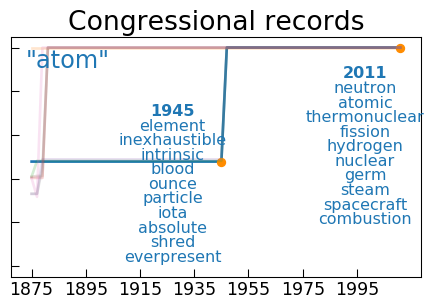

In [8]:
fig

In [9]:
# plot setting
start_year = 1875
end_year = 2011
incre = 2
k_neighbor = 10
tickgap = 10

target_words = ['broadcast']
print('id: ', vocab.index(target_words[0]))
time_interest = [(1893 - start_year)//2, (1969 - start_year)//2] #, (2011 - start_year)//2]
embeddings = embeddings_list[0]
canvas = plot_trajectory(target_words, time_interest, embeddings[int((start_year - 1875)//2):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap,
                         lcolor='C0', wcolor='C0', upwards=None, alpha=1.0,
                         pos=235, show_leftticklabels=False,
                         label_text='model with sparse changes (proposed)',
                         x_offset_list=[12, 12], y_offset_list=[-0.34, 0.1]
                        )

color = 1
for embeddings in embeddings_list[1:]:
    time_interest = [] #[(1895 - start_year)//2, (1971 - start_year)//2]
    canvas = plot_trajectory(target_words, time_interest, embeddings[int((start_year - 1875)//2):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap, 
                         canvas=canvas, lcolor='C%d' % color, wcolor='C%d' % color, upwards=None, alpha=ALPHA, updown_thres=0.5,
                         label_text="regular '%s' vectors" % target_words[0],
                         x_offset_list=[-3.0, -1], y_offset_list=[0.3, 0])
    color += 1
    


canvas.ax.axis['bottom'].set_label('year')
canvas.ax.axis['bottom'].label.set_fontsize(14)
canvas.ax.text(0, 1.0, '"%s"' % target_words[0], size=18, verticalalignment='top', color="C0")


id:  5426


Text(0, 1.0, '"broadcast"')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


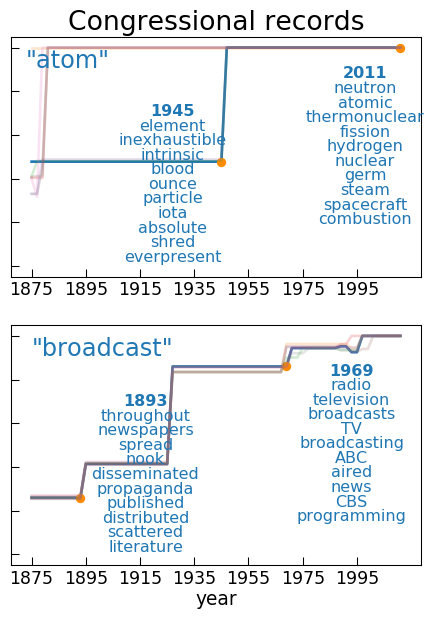

In [10]:
fig

## Google books
from `mult_diff as nonlinear broadening.ipynb`

PARAMS: v30000 d100 diff2 prior-10

plot 1900 - 2000

In [11]:
# subsampled vocabulary
vocab_size = 30000
vocab_path = './data-n-ckpt/gbooks/vocab_1900to2000_vocabsize30000.tsv'
with open(vocab_path) as file:
    file.readline() # skip first line
    tot_vocab = [line.split('\t')[0] for line in file.readlines()]
vocab = tot_vocab[:vocab_size]
print(np.asarray(vocab)[np.random.randint(0, 1000, 10)])

['from' 'structure' 'lines' 'live' 'All' 'extent' 'America' 'room' 'high'
 'test']


plot 1900 - 2000

In [12]:
# subsampled vocabulary
vocab_size = 30000
vocab_path = './data-n-ckpt/gbooks/vocab_1900to2000_vocabsize30000.tsv'
with open(vocab_path) as file:
    file.readline() # skip first line
    tot_vocab = [line.split('\t')[0] for line in file.readlines()]
vocab = tot_vocab[:vocab_size]
print(np.asarray(vocab)[np.random.randint(0, 1000, 10)])

# embeddings
end_year = 2000

beam_decision = np.load(
    './data-n-ckpt/gbooks/v30000_d100_b8_p-10_diff2.000000_gbooks/beam_results/'
    'beam_decision_v30000_d100_b8_y2000.npy')
beam_mu = np.load(
    './data-n-ckpt/gbooks/v30000_d100_b8_p-10_diff2.000000_gbooks/beam_mu_2000.npy')

beam_decision = np.asarray(beam_decision)
print(beam_decision[0].shape, beam_decision[1].shape)
print('shape of beam_decision', beam_decision.shape)
print('shape of beam_mu', beam_mu.shape)

# delayed update for embeddings
from local_jump_dsg_beam_search_crecords import delayed_update_procedure

beam_size = 8
beam_interest = 0
vocab_size = 30000
emb_dim = 100
num_years = end_year - 1900 + 1

embeddings_list = []
for beam_interest in range(beam_dize):
    embeddings_list.append(delayed_update_procedure(beam_decision, 
                                         beam_mu,
                                         num_years,
                                         update=True,
                                         beam_id=beam_interest, 
                                         vocab_size=vocab_size, emb_dim=emb_dim))

embeddings_list = np.array(embeddings_list)
print('(num_beam, num_years, num_words, num_dimensions): ', embeddings_list.shape)


['using' 'simple' 'probably' 'especially' 'activities' 'No.' 'soon' 'away'
 'children' '(']
(30000, 101) (30000, 101)
shape of beam_decision (8, 30000, 101)
shape of beam_mu (8, 30000, 100, 101)
(num_beam, num_years, num_words, num_dimensions):  (8, 101, 30000, 100)


In [13]:
# plot setting
start_year = 1900
end_year = 2000
incre = 1
k_neighbor = 10
tickgap = 20

target_words = ['computer']
print('id: ', vocab.index(target_words[0]))

embeddings = embeddings_list[0]
time_interest = [1920 - start_year, 1945 - start_year, 1954 - start_year]
canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1900):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap,
                         lcolor='C0', wcolor='C0', upwards=None, alpha=1.0,
                         figsize=(600/96, 500/96), pos=231,
                         label_text='model with sparse changes (proposed)',
                         x_offset_list=[-9.0, 35], y_offset_list=[0.05, 0.15])
    
color = 1
for embeddings in embeddings_list[1:]:
    time_interest = [1920 - start_year, ] # [1920 - start_year] #[(1895 - start_year)//2, (1971 - start_year)//2]
    canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1900):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap, 
                         canvas=canvas, lcolor='C%d' % color, wcolor='C%d' % color, upwards=None, alpha=ALPHA, updown_thres=0.5,
                         label_text="regular '%s' vectors" % target_words[0],
                         x_offset_list=[-3.0, -1], y_offset_list=[0.3, 0])
    color += 1

canvas.ax.text(0, 1.0, '"%s"' % target_words[0], size=18, verticalalignment='top', color="C0")

canvas.ax.set_title('Google books', fontsize=20)

canvas.ax.axis['left'].set_label('similarity to the latest meaning')
canvas.ax.axis['left'].label.set_fontsize(12)

id:  2980


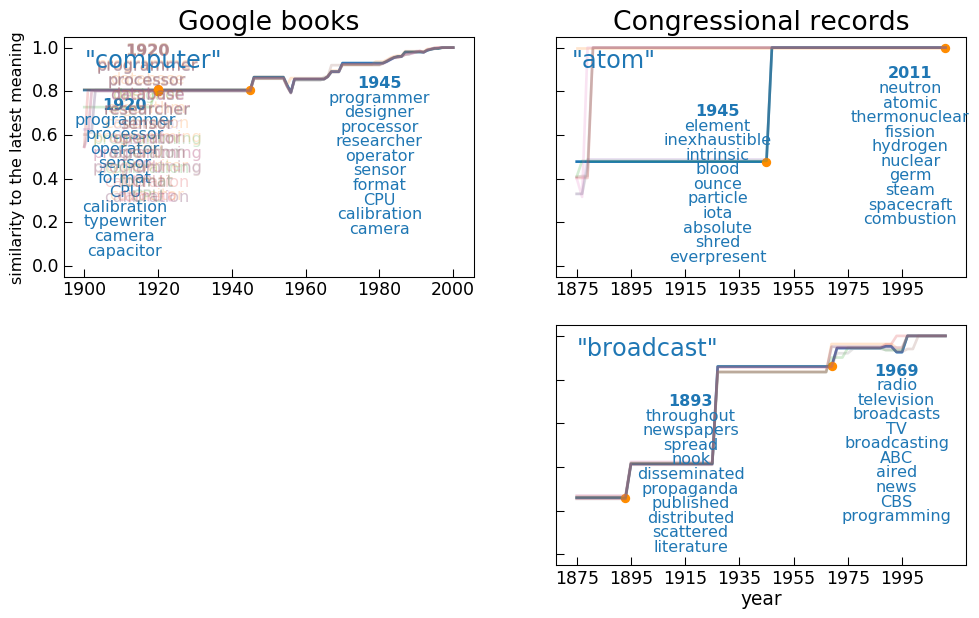

In [14]:
fig

In [15]:
# plot setting
start_year = 1900
end_year = 2000
incre = 1
k_neighbor = 10
tickgap = 20

target_words = ['simulation']
print('id: ', vocab.index(target_words[0]))
time_interest = [1933 - start_year, 1960 - start_year] #, 2000 - start_year]
embeddings = embeddings_list[0]
canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1900):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap,
                         lcolor='C0', wcolor='C0', upwards=None, alpha=1.0,
                         pos=234,
                         label_text='model with sparse changes (proposed)',
                         x_offset_list=[-21, 4, 0], y_offset_list=[-0.5, 0.05, 0])
    
    
color = 1
for embeddings in embeddings_list[1:]:
    time_interest = [] #[(1895 - start_year)//2, (1971 - start_year)//2]
    canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1900):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap, 
                         canvas=canvas, lcolor='C%d' % color, wcolor='C%d' % color, upwards=None, alpha=ALPHA, updown_thres=0.5,
                         label_text="regular '%s' vectors" % target_words[0],
                         x_offset_list=[-3.0, -1], y_offset_list=[0.3, 0])
    color += 1
    

canvas.ax.axis['left'].set_label('similarity to the latest meaning')
canvas.ax.axis['left'].label.set_fontsize(12)
canvas.ax.axis['bottom'].set_label('year')
canvas.ax.axis['bottom'].label.set_fontsize(14)

canvas.ax.text(-1., 1.0, '"%s"' % target_words[0], size=18, verticalalignment='top', color="C0")


id:  12273


Text(-1.0, 1.0, '"simulation"')

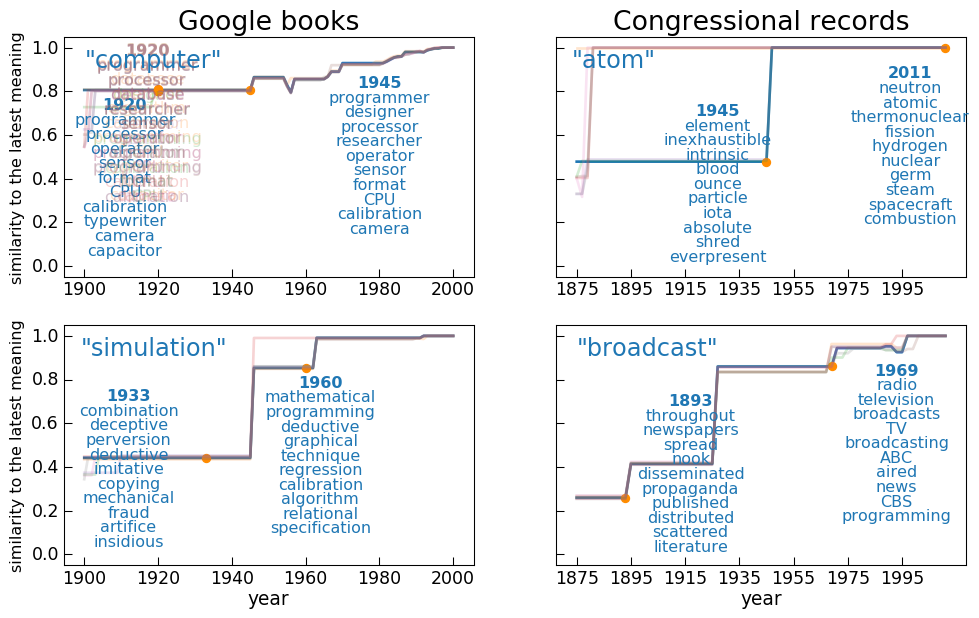

In [16]:
fig

## UN debates
from `local_jump_dsg_beam_search_undebates.ipynb`

PARAMS: v30000 d20 diff4 prior-1

plot 1970 - 2018

In [17]:
# vocabulary
vocab_size = 30000
vocab_path = './data-n-ckpt/un-debates/vocab100000.tsv'
with open(vocab_path) as file:
    file.readline() # skip first line
    tot_vocab = [line.split('\t')[0] for line in file.readlines()]
vocab = tot_vocab[:vocab_size]
print(np.asarray(vocab)[np.random.randint(0, 1000, 10)])

# embeddings
end_year = 2018

beam_decision = np.load(
    './data-n-ckpt/un-debates/v30000_d20_b8_p-1_diff4.000000_undebates/beam_results/beam_decision_v30000_d20_b8_y2018.npy')
beam_mu = np.load(
    './data-n-ckpt/un-debates/v30000_d20_b8_p-1_diff4.000000_undebates/beam_mu_2018.npy')

beam_decision = np.asarray(beam_decision)
print(beam_decision[0].shape, beam_decision[1].shape)
print('shape of beam_decision', beam_decision.shape)
print('shape of beam_mu', beam_mu.shape)

# delayed update for embeddings
from local_jump_dsg_beam_search_crecords import delayed_update_procedure

beam_dize = 8
beam_interest = 0
vocab_size = 30000
emb_dim = 20
num_years = 49

embeddings_list = []
for beam_interest in range(beam_dize):
    embeddings_list.append(delayed_update_procedure(beam_decision, 
                                         beam_mu,
                                         num_years,
                                         update=True,
                                         beam_id=beam_interest, 
                                         vocab_size=vocab_size, emb_dim=emb_dim))

embeddings_list = np.array(embeddings_list)
print('(num_beam, num_years, num_words, num_dimensions): ', embeddings_list.shape)



['strongly' 'partners' 'end' 'humankind' 'suffering' 'existing'
 'encourage' 'including' 'those' 'cent']
(30000, 49) (30000, 49)
shape of beam_decision (8, 30000, 49)
shape of beam_mu (8, 30000, 20, 49)
(num_beam, num_years, num_words, num_dimensions):  (8, 49, 30000, 20)


In [18]:
# plot setting
start_year = 1970
end_year = 2018
incre = 1
k_neighbor = 10
tickgap = 10

target_words = ['race']
print('id: ', vocab.index(target_words[0]))
time_interest = [1988 - start_year, 2018 - start_year]
embeddings = embeddings_list[0]
canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1970):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap,
                         lcolor='C0', wcolor='C0', upwards=None, alpha=1.0,
                         figsize=(600/96, 500/96), pos=233, show_leftticklabels=False,
                         label_text='model with sparse changes (proposed)',
                         x_offset_list=[2, -4], y_offset_list=[-0.05, 0.0])

color = 1
for embeddings in embeddings_list[1:]:
    time_interest = [] #[(1895 - start_year)//2, (1971 - start_year)//2]
    canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1970):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap, 
                         canvas=canvas, lcolor='C%d' % color, wcolor='C%d' % color, upwards=None, alpha=ALPHA, updown_thres=0.5,
                         label_text="regular '%s' vectors" % target_words[0],
                         x_offset_list=[-3.0, -1], y_offset_list=[0.3, 0])
    color += 1

canvas.ax.text(0, 1.0, '"%s"' % target_words[0], size=18, verticalalignment='top', color="C0")
canvas.ax.set_title('UN debates', fontsize=20)


id:  622


Text(0.5, 1.0, 'UN debates')

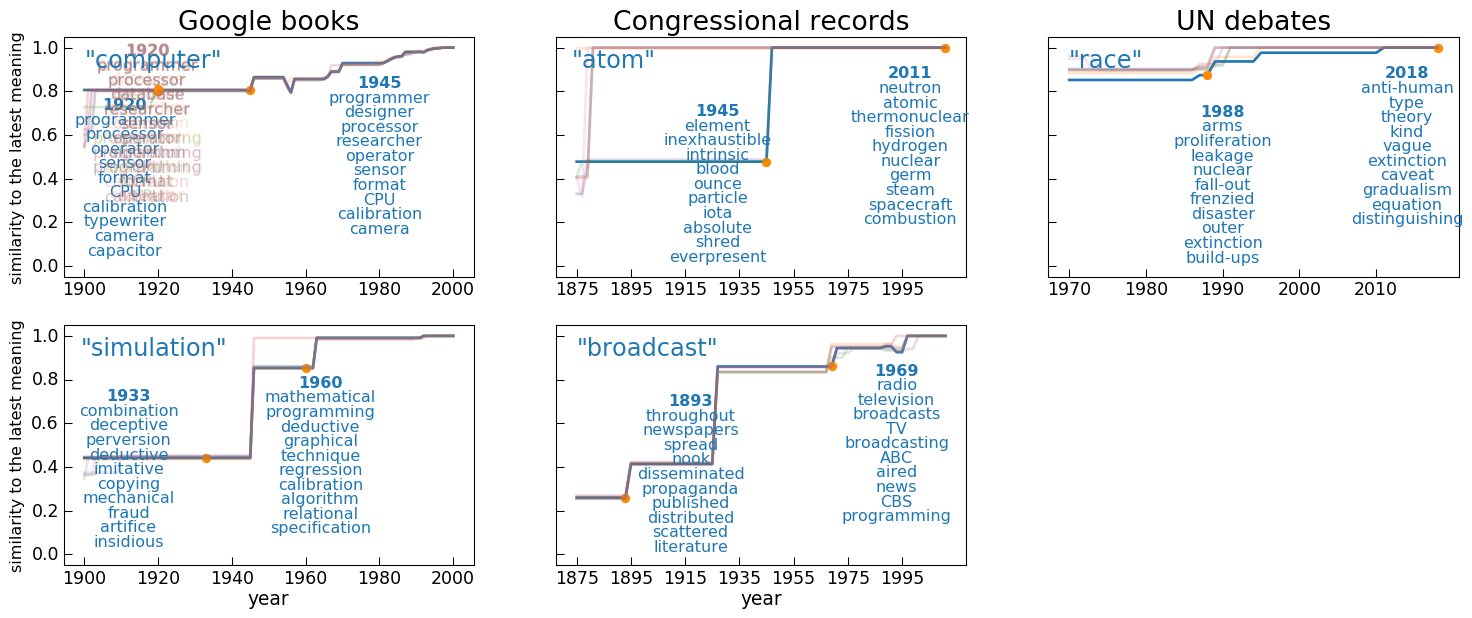

In [19]:
fig

In [20]:
# plot setting
start_year = 1970
end_year = 2018
incre = 1
k_neighbor = 10
tickgap = 10

target_words = ['climate']
print('id: ', vocab.index(target_words[0]))
time_interest = [1987 - start_year, 2000 - start_year]#, 2012 - start_year]
embeddings = embeddings_list[0]
canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1970):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap,
                         lcolor='C0', wcolor='C0', upwards=None, alpha=1.0,
                         figsize=(900/96, 500/96), pos=236, show_leftticklabels=False,
                         label_text='model with sparse changes (proposed)',
                         x_offset_list=[-1, 1, -5], y_offset_list=[0.15, 0, 0.05])
    
color = 1
for embeddings in embeddings_list[1:]:
    time_interest = [] #[(1895 - start_year)//2, (1971 - start_year)//2]
    canvas = plot_trajectory(target_words, time_interest, embeddings[int(start_year - 1970):,:,:], 
                         start_year=start_year, end_year=end_year, incre=incre, topk=k_neighbor, tickgap=tickgap, 
                         canvas=canvas, lcolor='C%d' % color, wcolor='C%d' % color, upwards=None, alpha=ALPHA, updown_thres=0.5,
                         label_text="regular '%s' vectors" % target_words[0],
                         x_offset_list=[-3.0, -1], y_offset_list=[0.3, 0])
    color += 1


canvas.ax.axis['bottom'].set_label('year')
canvas.ax.axis['bottom'].label.set_fontsize(14)


canvas.ax.text(0, 1.0, '"%s"' % target_words[0], size=18, verticalalignment='top', color="C0")


id:  281


Text(0, 1.0, '"climate"')

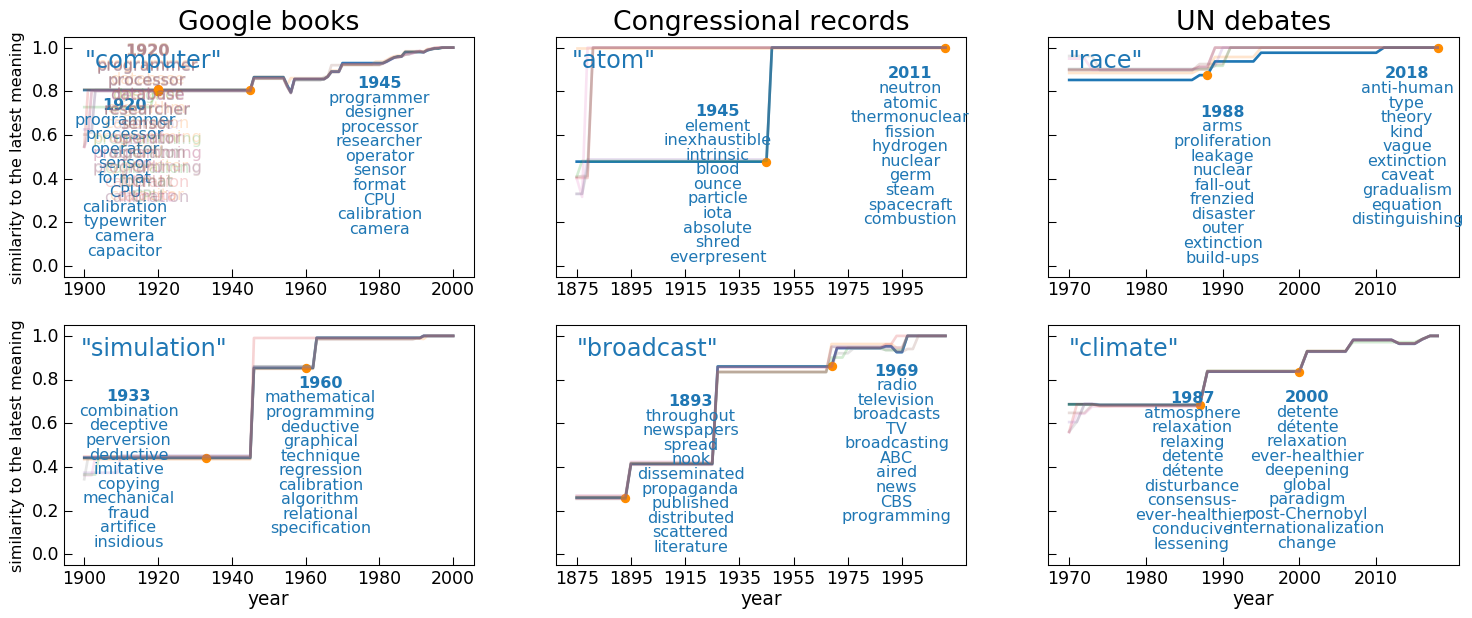

In [21]:
fig

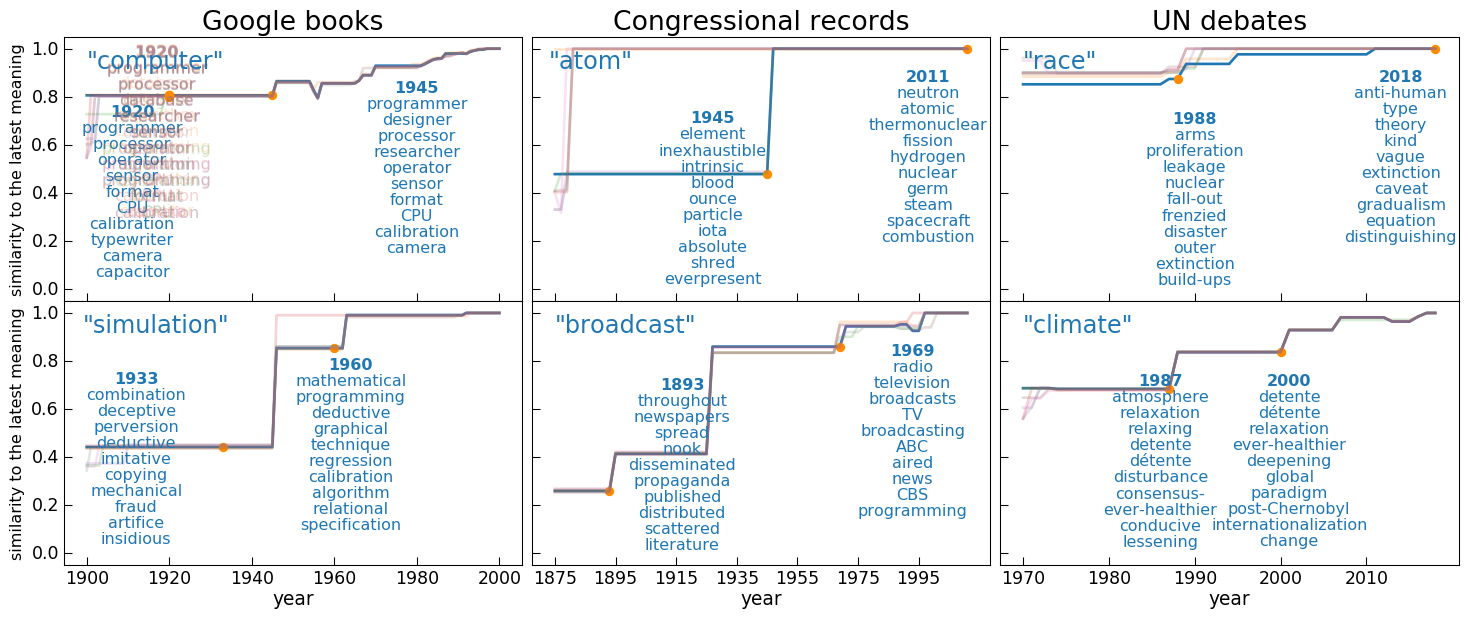

In [22]:
# fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0.02)
fig